<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Data-Prep" data-toc-modified-id="-Data-Prep-1"> Data Prep</a></span></li></ul></div>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
working_dir = os.getcwd()
data_path = os.path.dirname(working_dir) + '/data/'
print(data_path)

/Users/WillemCole/Desktop/Programming/DataScience/Projects/sf_building_complaints/data/


In [3]:
df = pd.read_csv(data_path + 'complaints.csv')

/Users/WillemCole/miniconda3/envs/sf_building_complaints/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


When we read the csv file we notice a DtypeWarning about mixed types in our complaint_number column which should be the index. We will fix this shortly.

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df.head()

,complaint_number,date_filed,date_abated,block,lot,street_number,street_name,street_suffix,unit,zip_code,complaint_description,status,receiving_division,assigned_division,last_inspection_date,date_1st_nov_issued,nov_type,date_2nd_nov_issued,closed_date,director_hearing_date,final_warning_letter_issued,parcel_number,analysis_neighborhood,supervisor_district,point,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_jx4q_fizf,:@computed_region_bh8s_q3mv,:@computed_region_jwn9_ihcz,date_referred_to_city_attorney
0,H9504209,1995-12-05T00:00:00.000,1995-12-06T00:00:00.000,0822,029,969,Hayes,St,2.0,94117.0,Illegal unit in back.,Not Active,Housing Inspection Services,Building Inspection Division,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H9601135,1996-03-12T00:00:00.000,1996-03-19T00:00:00.000,1364,003,121,4th,Av,NaN,94118.0,Illegal demolition,Not Active,Housing Inspection Services,Building Inspection Division,1996-03-15T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H9403757,1994-10-21T00:00:00.000,1994-10-31T00:00:00.000,6652,023,1731,Noe,St,NaN,94131.0,No heat since 25th of august/.,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,199600880,1996-09-03T00:00:00.000,1996-09-03T00:00:00.000,2699,041,315,Douglass,St,NaN,94114.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,199602151,1996-11-12T00:00:00.000,1997-01-31T00:00:00.000,0606,017,2400,Steiner,St,NaN,94115.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,1996-11-12T00:00:00.000,1996-11-12T00:00:00.000,Routine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#view the shape of our dataset
df.shape

(267467, 35)

In [7]:
#view a sample of 10 complaint_numbers where the complaint contains a character instead of digit
#this will help us understand why pandas couldn't parse this column as the index which was done in our fetch_data file
df.loc[~df['complaint_number'].astype(str).str.isdigit(), 'complaint_number'].sample(10)

8483     H9403323
8449     H9500237
9981     H9501434
6164     H9400804
222      H9601371
1487     H9403367
11625    H9404513
1802     H9502249
12704    H9502385
8456     H9501600
Name: complaint_number, dtype: object

In [8]:
#replace the H's that occur in the complaint_number with ''
df['complaint_number'] = pd.to_numeric(df['complaint_number'].replace('H','', regex = True))
#set the index to the new complaint_number
df.set_index('complaint_number', inplace = True)

In [9]:
#check for duplicate rows
df.duplicated().sum()

460

In [10]:
#check data types
df.dtypes

date_filed                         object
date_abated                        object
block                              object
lot                                object
street_number                       int64
street_name                        object
street_suffix                      object
unit                              float64
zip_code                          float64
complaint_description              object
status                             object
receiving_division                 object
assigned_division                  object
last_inspection_date               object
date_1st_nov_issued                object
nov_type                           object
date_2nd_nov_issued                object
closed_date                        object
director_hearing_date              object
final_warning_letter_issued        object
parcel_number                      object
analysis_neighborhood              object
supervisor_district               float64
point                             

In [11]:
#examine a sample of complaint descriptions
display(df.complaint_description.sample(10))

complaint_number
200234542    2 illegal in-laws #1 in lower level of main ho...
199814267    Possible illegal unit in basement behind garag...
201600301    Complete demolish of the concrete foundation a...
200119270    Excessive heat in the apartment.radiator unit ...
200116042              Child care in church "needs attention".
201581542    Roof is being ripped apart and construction wo...
202172524    Health & safety problems: face_covering additi...
201404541    Plumbing work upstairs and downstairs w/o perm...
200230491                                   Routine inspection
200224153                                   Routine inspection
Name: complaint_description, dtype: object

In [12]:
#determine where null values are located
df.isna().sum()

date_filed                             0
date_abated                        76026
block                                  0
lot                                    0
street_number                          0
street_name                            0
street_suffix                          0
unit                              232318
zip_code                            1076
complaint_description                432
status                                 0
receiving_division                     0
assigned_division                      8
last_inspection_date              134345
date_1st_nov_issued               157959
nov_type                          173684
date_2nd_nov_issued               256858
closed_date                       197523
director_hearing_date             252512
final_warning_letter_issued       248762
parcel_number                       3719
analysis_neighborhood               3715
supervisor_district                 3715
point                               3704
:@computed_regio

In [13]:
#drop the columns that have null complaint descriptions
df.dropna(subset = ['complaint_description'], inplace = True)

In [14]:
#group the most common 20 complaint descriptions
common_complaints = df.complaint_description.value_counts().sort_values(ascending = False).head(20)

print(common_complaints)

Routine inspection                                                       19466
Routine                                                                  12653
Routine safety inspection                                                 4664
Routine inspection.                                                       1584
Routines.                                                                 1519
Vacant storefront                                                         1506
Routines                                                                  1317
Vacant building                                                           1176
No heat                                                                   1023
Unsafe bldg.                                                               963
Routine inspection of common areas of subject property.                    924
Routine apartment house inspection                                         882
Health and safety inspection of apartment house. sec

In [15]:
# create a dataset sorted by common complaint description 
#note we multiply the size of each group by -1 to sort in descending order
#ascending = False doesn't work with argsort
sorted_complaints = df.iloc[df.groupby('complaint_description').complaint_description.transform('size') \
          .mul(-1).argsort(kind='mergesort')].head(common_complaints.sum())

In [16]:
#here we can view the most common complaint descriptions
#we see that the majority of the "routine" complaints are assigned to Housing Inspection Services
complaints_by_division = sorted_complaints.groupby(['assigned_division']) \
                    ['complaint_description'].value_counts() \
                    .sort_values(ascending = False).to_frame() \
                    .rename(columns={'complaint_description':'complaint_count'}).reset_index()

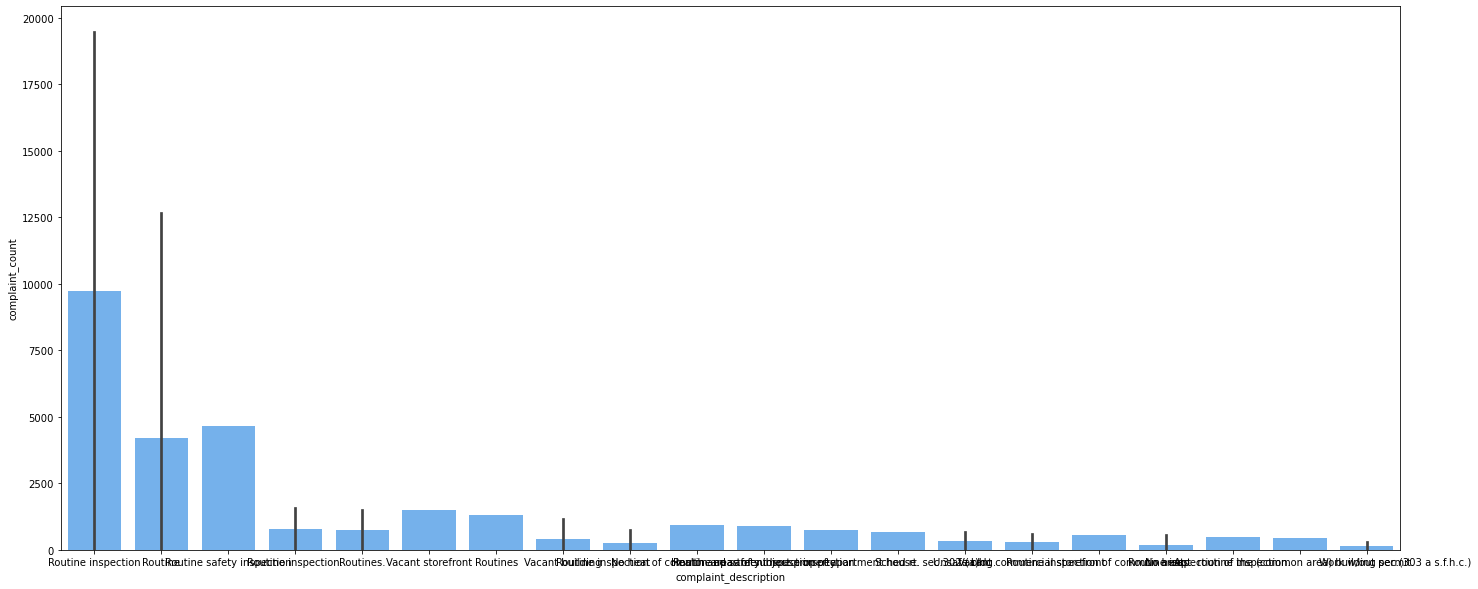

In [17]:
fig, ax = plt.subplots(figsize=(24,10))

ax = sns.barplot(x=complaints_by_division['complaint_description'], 
                 y=complaints_by_division['complaint_count'], color='dodgerblue', 
                 alpha = .7)

In [18]:
#create a df of complaints that were reassigned from their original location
reassigned = df.loc[(df['receiving_division'] != df['assigned_division'])]

In [19]:
common_reassigned = reassigned.complaint_description.value_counts().sort_values(ascending = False).head(20)

In [20]:
sorted_reassigned = reassigned.iloc[reassigned.groupby('complaint_description').complaint_description.transform('size') \
          .mul(-1).argsort(kind='mergesort')].head(common_reassigned.sum())

In [21]:
reassigned_by_division = sorted_reassigned.groupby(['assigned_division']) \
                    ['complaint_description'].value_counts() \
                    .sort_values(ascending = False).to_frame() \
                    .rename(columns={'complaint_description':'complaint_count'}).reset_index()  

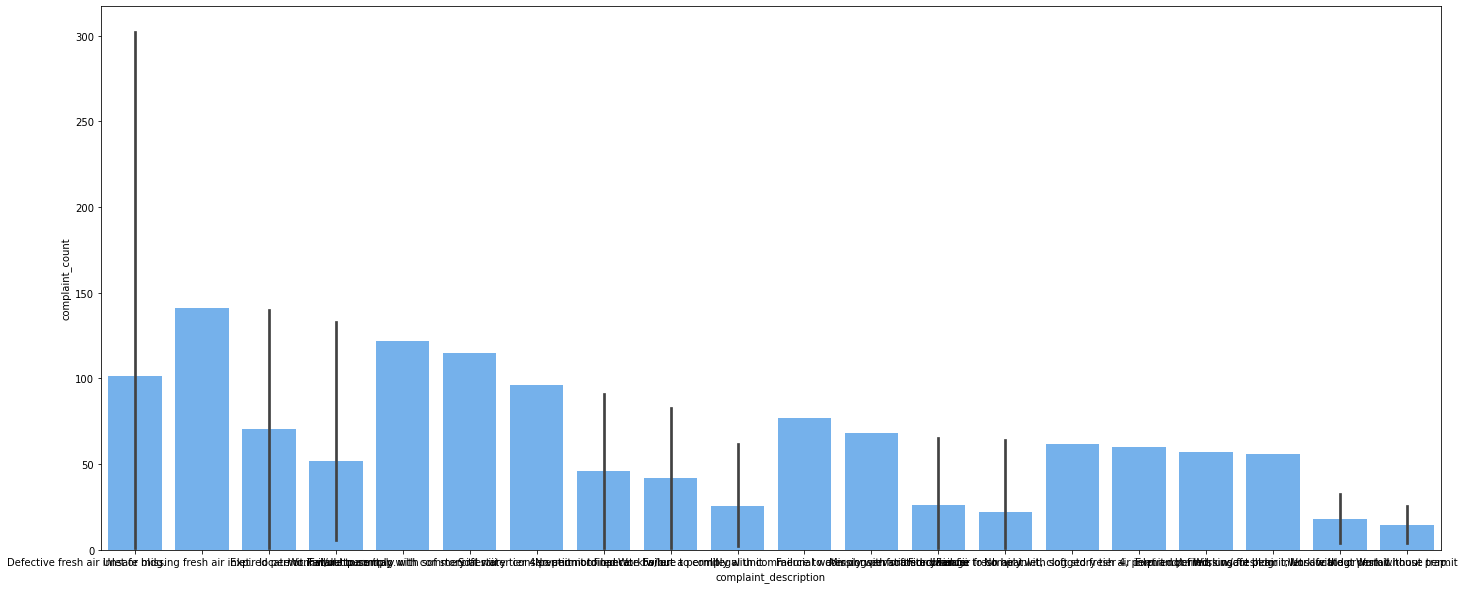

In [22]:
#we can see that complaints that were reassigned have a much larger dispersion
fig, ax = plt.subplots(figsize=(24,10))

ax = sns.barplot(x=reassigned_by_division['complaint_description'], 
                 y=reassigned_by_division['complaint_count'], color='dodgerblue', 
                 alpha = .7)

<h1> Data Prep</h1>

In [23]:
df["complaint_description"].str.len().max()

1000

In [24]:
# print(f" - max length:   {np.max(df.complaint_description)}")
# print(f" - min length:   {np.min(df.complaint_description)}")
# print(f" - mean length:  {np.mean(df.complaint_description)}")